In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36175")
client

<Client: 'tcp://127.0.0.1:36175' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'

In [5]:
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures

# Compute eddy flux and diabatic flux

Eddy flux $F = (\bar{\sigma}^{-1} \nabla \cdot \mathbf{E}^{v} ) \mathbf{e}_1 - (\bar{\sigma}^{-1} \nabla \cdot \mathbf{E}^u) \mathbf{e}_2$

Diabatic flux $\Gamma = \bar{\sigma}^{-1}(-\hat{\mathcal{Y}} + \hat{v}_{\tilde{b}} \hat{\varpi}) \bar{\mathbf{e}}_1 + \bar{\sigma}^{-1}(\hat{\mathcal{X}} - \hat{u}_{\tilde{b}} \hat{\varpi}) \bar{\mathbf{e}}_2$

In [6]:
year = years[0]

for itime in ntimes[0]:
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)

    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
#     dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
#                                % (year,itime))
#                       ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                   YG=slice(ystart-12**-1,yend+2*12**-1)
#                                                    ).chunk({'YC':ychunk,'XC':xchunk})
    
    ds_div = xr.open_zarr(op.join(savedir,twadir,'run%4d/divE-P/%010d/' 
                                            % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)

    delta = .5*(dsz.delta_outer[1:].data 
                + dsz.delta_outer[:-1].data)
    dsz.coords['delta'] = ('delta',delta)

    grid = Grid(dsz, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
           )

    buoyb = -grav * dsz.delta * rho0**-1
    buoybp1 = -grav * dsz.delta_outer * rho0**-1

    sigmab = (dsz.dzetab * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    sigmaxb = (dsz.dzetaxb * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    sigmayb = (dsz.dzetayb * -grid.diff(buoyb,'Z',boundary='extend')**-1)
    
    # Eddy fluxes        
    Fu = sigmaxb ** -1 * grid.interp(ds_div.e01x + ds_div.e11y 
                         + ds_div.e21_0b + ds_div.e21_1b,
                                    'X')
    Fv = - sigmayb ** -1 * grid.interp(ds_div.e00x + ds_div.e10y 
                           + ds_div.e20_0b + ds_div.e20_1b, 
                                       'Y')
    # Diabatic fluxes
    uhat = dsb.uhat
    vhat = dsb.vhat
    varpihat = dsb.varpihat
    AB_gUhat = dsb.AB_gUhat
    AB_gVhat = dsb.AB_gVhat
    XFhat = dsb.XFhat
    YFhat = dsb.YFhat
    
    duhatdb = grid.interp(grid.diff(uhat,'Z',boundary='extend') 
                              * grid.diff(buoybp1,'Z',boundary='extend')**-1,
                              'Z',boundary='extend')
    dvhatdb = grid.interp(grid.diff(vhat,'Z',boundary='extend') 
                              * grid.diff(buoybp1,'Z',boundary='extend')**-1,
                              'Z',boundary='extend')
    
    Gu = grid.interp(- grid.interp(YFhat + AB_gVhat, 'Y') 
          + grid.interp(dvhatdb, 'Y') * varpihat, 'X') * sigmaxb ** -1  
    Gv = grid.interp(grid.interp(XFhat + AB_gUhat, 'X') 
                     - grid.interp(duhatdb, 'X') * varpihat, 'Y') * sigmayb ** -1
    
    # # PV fluxes
    # Ju = dsPV.Ju  # through W(-1) and E(1)
    # Jv = dsPV.Jv # through S(-1) and N(1)
    
    ds.close()
    dsb.close()
    dsz.close()
    ds_div.close()
    
    
    dsave1 = Fu.to_dataset(name='Fu').chunk({'YC':ychunk,'XG':xchunk})   
    dsave1['Fv'] = Fv.chunk({'YG':ychunk,'XC':xchunk})
    dsave1.to_zarr(op.join(savedir,twadir,'run%4d/Eddy_flux/%010d/' 
                                            % (year,itime)), mode='w')
    dsave1.close()
    
    dsave2 = Gu.to_dataset(name='Gu').chunk({'YC':ychunk,'XG':xchunk})   
    dsave2['Gv'] = Gv.chunk({'YG':ychunk,'XC':xchunk})
    dsave2.to_zarr(op.join(savedir,twadir,'run%4d/Diabatic_flux/%010d/' 
                                            % (year,itime)), mode='w')
    dsave2.close()

    
    print(itime)

1419120
1421280
1423440
1425600
1427760
1429920
1432080
1434240
1436400
1438560
1440720
1442880
1445040
1447200
1449360
1451520
1453680
1455840
1458000
1460160
1462320
1464480
1466640
1468800
1470960
1473120
1475280
1477440
1479600
1481760
1483920
1486080
1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


# Animation of fluxes

We have determined the box in which the control volume evolves. So we focus on one layer (b = -0.25, delta_index = 25) to animate the mean flux, eddy flux and diabatic flux. Layer study is enough since we are interested in the fluxes through the boundaries of the control volume. 

/tmp/ipykernel_322547/1348134734.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  caxes.set_yticklabels([-1, 0, 1])
/tmp/ipykernel_322547/1348134734.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  caxes.set_yticklabels([-1, 0, 1])
/tmp/ipykernel_322547/1348134734.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  caxes.set_yticklabels([-1, 0, 1])


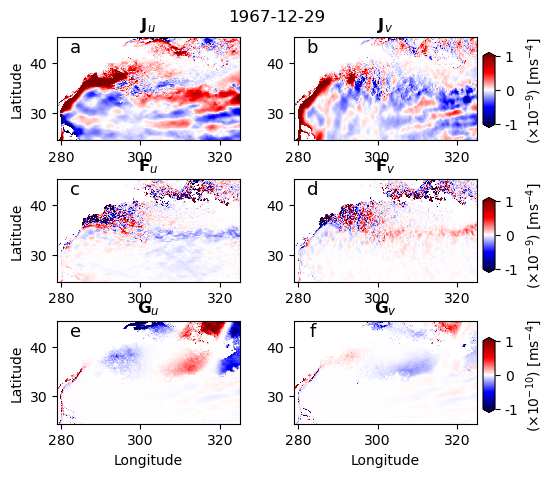

In [37]:
writer = animation.FFMpegWriter(fps=7, metadata=dict(artist='Me'), bitrate=-1)
fig, ax = plt.subplots(figsize=(6,5), nrows=3, ncols=2)
fig.tight_layout()
plt.subplots_adjust(top = 0.85, left=0.1, right = 0.8)

XG_sub = [279, 325]
YG_sub = [24.5, 45.2]

delta_index = 21

ims=[]
count = 0 
year = years[0]
for itime in ntimes[0]:    
    # read files
    dsF = xr.open_zarr(op.join(savedir,twadir,'run%4d/Eddy_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Fu = dsF.Fu.isel(delta_outer = delta_index).sel(
                     XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1]))
    Fv = dsF.Fv.isel(delta_outer = delta_index).sel(
                     XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1]))
    
    dsG = xr.open_zarr(op.join(savedir,twadir,'run%4d/Diabatic_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Gu = dsG.Gu.isel(delta_outer = delta_index).sel(
                     XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1]))
    Gv = dsG.Gv.isel(delta_outer = delta_index).sel(
                     XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1]))
    
    dsJ = xr.open_zarr(op.join(savedir,twadir,'run%4d/mean_PV_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    
    Ju = dsJ.Ju.isel(delta_outer = delta_index).sel(
                     XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])) 
    Jv = dsJ.Jv.isel(delta_outer = delta_index).sel(
                     XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1])) 
    
    dsF.close()
    dsG.close()
    dsJ.close()
    
    # plot fields
     
    im00 = ax[0,0].pcolormesh(Ju.XG, Ju.YC, Ju, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )     
    label00 = ax[0,0].text(0.1, 0.9, 'a', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[0,0].transAxes)
    ax[0,0].set_ylabel('Latitude')
    ax[0,0].set_title(r'$\mathbf{J}_u$')
    
    im01 = ax[0,1].pcolormesh(Jv.XC, Jv.YG, Jv, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )   
    label01 = ax[0,1].text(0.1, 0.9, 'b', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[0,1].transAxes)
    # ax[0,1].set_ylabel('Latitude')
    ax[0,1].set_title(r'$\mathbf{J}_v$')
    if count == 0:
        caxes = fig.add_axes((0.81, 0.67, 0.02, 0.15))
        cbar = fig.colorbar(im00, cax = caxes,
                            orientation='vertical', shrink=.7, extend = 'both')
        caxes.set_yticklabels([-1, 0, 1])
        cbar.set_label(r'$ (\times 10^{-9})$ [ms$^{-4}$]', fontsize=10)
        
        
    
    im10 = ax[1,0].pcolormesh(Fu.XG, Fu.YC, Fu, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )     
    label10 = ax[1,0].text(0.1, 0.9, 'c', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[1,0].transAxes)
    ax[1,0].set_ylabel('Latitude')
    ax[1,0].set_title(r'$\mathbf{F}_u$')
    
    im11 = ax[1,1].pcolormesh(Fv.XC, Fv.YG, Fv, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )   
    label11 = ax[1,1].text(0.1, 0.9, 'd', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[1,1].transAxes)
    # ax[0,1].set_ylabel('Latitude')
    ax[1,1].set_title(r'$\mathbf{F}_v$')
    if count == 0:
        caxes = fig.add_axes((0.81, 0.38, 0.02, 0.15))
        cbar = fig.colorbar(im10, cax = caxes,
                            orientation='vertical', shrink=.7, extend = 'both')
        caxes.set_yticklabels([-1, 0, 1])
        cbar.set_label(r'$ (\times 10^{-9})$ [ms$^{-4}$]', fontsize=10)
        
    im20 = ax[2,0].pcolormesh(Gu.XG, Gu.YC, Gu, 
                        vmin=-1e-10, vmax=1e-10, cmap='seismic', 
                        rasterized=True
                       )     
    label20 = ax[2,0].text(0.1, 0.9, 'e', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[2,0].transAxes)
    ax[2,0].set_ylabel('Latitude')
    ax[2,0].set_xlabel('Longitude')
    ax[2,0].set_title(r'$\mathbf{G}_u$')
    
    im21 = ax[2,1].pcolormesh(Gv.XC, Gv.YG, Gv, 
                        vmin=-1e-10, vmax=1e-10, cmap='seismic', 
                        rasterized=True
                       )   
    label21 = ax[2,1].text(0.1, 0.9, 'f', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[2,1].transAxes)
    ax[2,1].set_xlabel('Longitude')
    ax[2,1].set_title(r'$\mathbf{G}_v$')
    if count == 0:
        caxes = fig.add_axes((0.81, 0.1, 0.02, 0.15))
        cbar = fig.colorbar(im20, cax = caxes,
                            orientation='vertical', shrink=.7, extend = 'both')
        caxes.set_yticklabels([-1, 0, 1])
        cbar.set_label(r'$ (\times 10^{-10})$ [ms$^{-4}$]', fontsize=10)
        
    ttl = plt.text(1.2, 1.2, str(dates.date[count]),
               horizontalalignment = 'center',  fontsize = 12,
               verticalalignment = 'center', transform = ax[0,0].transAxes)
    
    ims.append([im00,im01,im10,im11,im20,im21,#cim0,cim1,cim2,
               label00,label01,label10,label11,
               label20,label21,ttl])  
    count += 1
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat = True, repeat_delay=50)
ani.save(figdir+'Fluxes.mp4', writer=writer)
    
    

# Diagnosis of snapshots

/tmp/ipykernel_322547/3261629661.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  caxes.set_yticklabels([-1, 0, 1])
/tmp/ipykernel_322547/3261629661.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  caxes.set_yticklabels([-1, 0, 1])


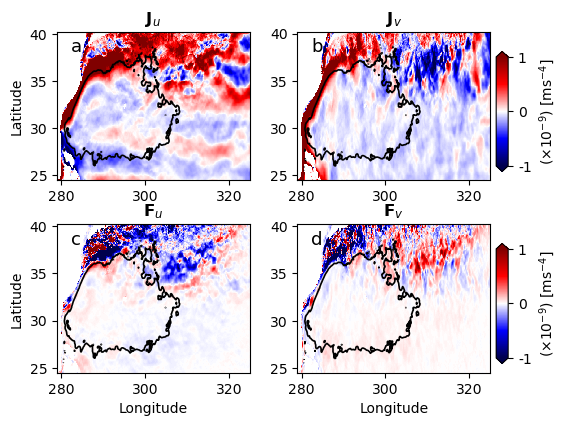

In [12]:
fig, ax = plt.subplots(figsize=(6,4), nrows=2, ncols=2)
fig.tight_layout()
plt.subplots_adjust(right = 0.8)

XG_sub = [279, 325]
YG_sub = [24.5, 40.2]

delta_index = 21

year = years[0]
for itime in ntimes[0,31:32]:    
    # read files
    dsJ = xr.open_zarr(op.join(savedir,twadir,'run%4d/mean_PV_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Ju = dsJ.Ju.isel(delta_outer = delta_index).sel(
                     XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1])) 
    Jv = dsJ.Jv.isel(delta_outer = delta_index).sel(
                     XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1])) 
    
    dsF = xr.open_zarr(op.join(savedir,twadir,'run%4d/Eddy_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Fu = dsF.Fu.isel(delta_outer = delta_index).sel(
                     XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1]))
    Fv = dsF.Fv.isel(delta_outer = delta_index).sel(
                     XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1]))
    
    dsG = xr.open_zarr(op.join(savedir,twadir,'run%4d/Diabatic_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Gu = dsG.Gu.isel(delta_outer = delta_index).sel(
                     XG = slice(XG_sub[0],XG_sub[1]), 
                     YC = slice(YG_sub[0],YG_sub[1]))
    Gv = dsG.Gv.isel(delta_outer = delta_index).sel(
                     XC = slice(XG_sub[0],XG_sub[1]), 
                     YG = slice(YG_sub[0],YG_sub[1]))
    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   )
    Pi = dsPV.Pi.isel(delta_outer = delta_index).sel(
                         XG = slice(XG_sub[0],XG_sub[1]), 
                         YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
    
    
    
    dsF.close()
    dsG.close()
    dsJ.close()
    dsPV.close()
    
    # plot fields
     
    im00 = ax[0,0].pcolormesh(Ju.XG, Ju.YC, Ju, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )     
    label00 = ax[0,0].text(0.1, 0.9, 'a', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[0,0].transAxes)
    ax[0,0].set_ylabel('Latitude')
    ax[0,0].set_title(r'$\mathbf{J}_u$')
    
    im01 = ax[0,1].pcolormesh(Jv.XC, Jv.YG, Jv, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )   
    label01 = ax[0,1].text(0.1, 0.9, 'b', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[0,1].transAxes)
    # ax[0,1].set_ylabel('Latitude')
    ax[0,1].set_title(r'$\mathbf{J}_v$')
    
    caxes = fig.add_axes((0.81, 0.6, 0.02, 0.3))
    cbar = fig.colorbar(im00, cax = caxes,
                        orientation='vertical', shrink=.7, extend = 'both')
    caxes.set_yticklabels([-1, 0, 1])
    cbar.set_label(r'$ (\times 10^{-9})$ [ms$^{-4}$]', fontsize=10)

        
    
    im10 = ax[1,0].pcolormesh(Fu.XG, Fu.YC, Fu, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )     
    label10 = ax[1,0].text(0.1, 0.9, 'c', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[1,0].transAxes)
    ax[1,0].set_ylabel('Latitude')
    ax[1,0].set_title(r'$\mathbf{F}_u$')
    ax[1,0].set_xlabel('Longitude')
    
    im11 = ax[1,1].pcolormesh(Fv.XC, Fv.YG, Fv, 
                        vmin=-1e-9, vmax=1e-9, cmap='seismic', 
                        rasterized=True
                       )   
    label11 = ax[1,1].text(0.1, 0.9, 'd', 
               horizontalalignment = 'center', fontsize=13,
               verticalalignment = 'center', transform = ax[1,1].transAxes)
    ax[1,1].set_xlabel('Longitude')
    ax[1,1].set_title(r'$\mathbf{F}_v$')
    
    caxes = fig.add_axes((0.81, 0.12, 0.02, 0.3))
    cbar = fig.colorbar(im10, cax = caxes,
                        orientation='vertical', shrink=.7, extend = 'both')
    caxes.set_yticklabels([-1, 0, 1])
    cbar.set_label(r'$ (\times 10^{-9})$ [ms$^{-4}$]', fontsize=10)

    ax[0,0].contour(Pi.XG, Pi.YG, Pi,
                levels = [0.25e-9], linewidths=1.2, colors='k')
    ax[0,1].contour(Pi.XG, Pi.YG, Pi,
                levels = [0.25e-9], linewidths=1.2, colors='k')
    ax[1,0].contour(Pi.XG, Pi.YG, Pi,
                levels = [0.25e-9], linewidths=1.2, colors='k')
    ax[1,1].contour(Pi.XG, Pi.YG, Pi,
                levels = [0.25e-9], linewidths=1.2, colors='k')
    
    plt.savefig(figdir+'Fluxes_Jun07_b25.eps', format = 'eps', dpi= 600, 
            bbox_inches = 'tight', pad_inches = 0.1)
    plt.show() 

# Totol flux through control volume

In [40]:
for itime in ntimes[70:71]: # 30 - 61     
    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                           % (year,itime))
                  ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk}) 

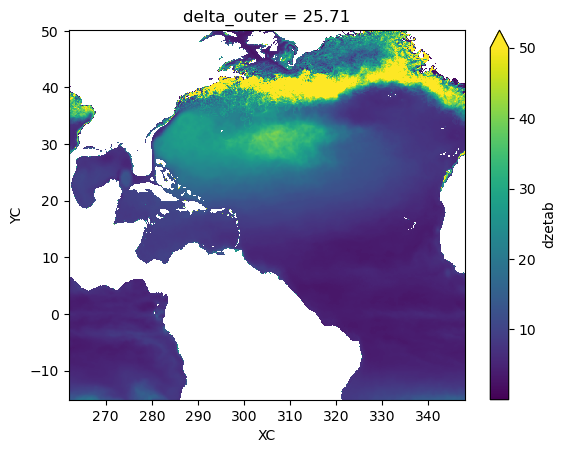

In [47]:
dsz.dzetab.isel(delta_outer = 23).plot(vmax = 50)

In [6]:
Pi_thres = 0.25e-9
year = years[0]
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,1],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
tot_F = np.zeros([73,9])
tot_J = np.zeros([73,9])
tot_G = np.zeros([73,9])
count = 0
for itime in ntimes[0]: # 30 - 61     
    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                           % (year,itime))
                  ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk}) 
    dsm = xr.open_zarr(op.join(savedir,twadir,'run%4d/PV_mask_%2d/%010d/' 
                                                % (year,Pi_thres *1e11,itime)
                              ))
    
    dsJ = xr.open_zarr(op.join(savedir,twadir,'run%4d/mean_PV_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    
    dsF = xr.open_zarr(op.join(savedir,twadir,'run%4d/Eddy_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
   
    
    dsG = xr.open_zarr(op.join(savedir,twadir,'run%4d/Diabatic_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
   
    
#     dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
#                                % (year,itime))
#                       ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                   YG=slice(ystart-12**-1,yend+2*12**-1)
#                                                    ).chunk({'YC':ychunk,'XC':xchunk})
 
    count2 = 0
    for dd in dsm.delta_outer:
       
        mask = dsm.mask.sel(delta_outer = dd)
        mask_b = dsm.mask_b.sel(delta_outer = dd)
        
        # read fluxes
        Fu = dsF.Fu.sel(delta_outer = dd, XG = mask.XG.values,
                                              YC = mask.YG.values, 
                       method = 'nearest')
        Fv = dsF.Fv.sel(delta_outer = dd, XC = mask.XG.values, 
                                              YG = mask.YG.values, 
                       method = 'nearest')
    
        Gu = dsG.Gu.sel(delta_outer = dd, XG = mask.XG.values,
                                              YC = mask.YG.values, 
                       method = 'nearest')
        Gv = dsG.Gv.sel(delta_outer = dd, XC = mask.XG.values, 
                                              YG = mask.YG.values, 
                       method = 'nearest')
    
        Ju = dsJ.Ju.sel(delta_outer = dd, XG = mask.XG.values,
                                              YC = mask.YG.values, 
                       method = 'nearest')
        Jv = dsJ.Jv.sel(delta_outer = dd, XC = mask.XG.values, 
                                              YG = mask.YG.values, 
                       method = 'nearest')
        #update grid    
        grid = Grid(dsz.sel(XC = mask.XG.values, XG = mask.XG.values,
                       YC = mask.YG.values, YG = mask.YG.values, 
                       method = 'nearest'),
                    coords={'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )
        # select points on four boundaries 
        w_bdr = (xr.where(mask_b == 1, 1, 0) # W
                  + xr.where(mask_b == 7, 1, 0) # NW_e
                  + xr.where(mask_b == 4, 1, 0) # SW_e
                  + xr.where(mask_b == 10, 1, 0) # SW_i
                  + xr.where(mask_b == 11, 1, 0) # NW_i
                 )

        e_bdr = (xr.where(mask_b == 2, 1, 0) # E
                  + xr.where(mask_b == 8, 1, 0) # NE_e
                  + xr.where(mask_b == 5, 1, 0) # SE_e
                  + xr.where(mask_b == 12, 1, 0) # SE_i
                  + xr.where(mask_b == 13, 1, 0) # NE_i
                 )

        s_bdr = (xr.where(mask_b == 3, 1, 0) # S
                  + xr.where(mask_b == 4, 1, 0) # SW_e
                  + xr.where(mask_b == 5, 1, 0) # SE_e
                  + xr.where(mask_b == 10, 1, 0) # SW_i
                  + xr.where(mask_b == 12, 1, 0) # SE_i
                 )

        n_bdr = (xr.where(mask_b == 6, 1, 0) # N
                  + xr.where(mask_b == 8, 1, 0) # NE_e
                  + xr.where(mask_b == 7, 1, 0) # NW_e
                  + xr.where(mask_b == 11, 1, 0) # NW_i
                  + xr.where(mask_b == 13, 1, 0) # NE_i
                 )

        # interpolate mask on (XG,YG) to (XC,YG) and (XG,YC)
        w_bdr_interp = grid.interp(w_bdr, 'Y').where(grid.interp(w_bdr, 'Y') == 1, 0)
        e_bdr_interp = grid.interp(e_bdr, 'Y').where(grid.interp(e_bdr, 'Y') == 1, 0)
        s_bdr_interp = grid.interp(s_bdr, 'X').where(grid.interp(s_bdr, 'X') == 1, 0)
        n_bdr_interp = grid.interp(n_bdr, 'X').where(grid.interp(n_bdr, 'X') == 1, 0)

        
        dxG = ds.dxG.sel(XC = mask.XG.values, 
                       YG = mask.YG.values, 
                       method = 'nearest')
        dyG = ds.dyG.sel(XG = mask.XG.values, 
                       YC = mask.YG.values, 
                       method = 'nearest')
        dzetaxb = dsz.dzetaxb.sel(XG = mask.XG.values,
                                YC = mask.YG.values, 
                                method = 'nearest').sel(delta_outer = dd)
        dzetayb = dsz.dzetayb.sel(XC = mask.XG.values,
                                YG = mask.YG.values, 
                                method = 'nearest').sel(delta_outer = dd)
        
        
        # compute fluxes through boundaries 
        Ju_we = (Ju * e_bdr_interp - Ju * w_bdr_interp) * dyG * dzetaxb
        Jv_ns = (Jv * n_bdr_interp - Jv * s_bdr_interp) * dxG * dzetayb
        
        Fu_we = (Fu * e_bdr_interp - Fu * w_bdr_interp) * dyG * dzetaxb
        Fv_ns = (Fv * n_bdr_interp - Fv * s_bdr_interp) * dxG * dzetayb
        
        Gu_we = (Gu * e_bdr_interp - Gu * w_bdr_interp) * dyG * dzetaxb
        Gv_ns = (Gv * n_bdr_interp - Gv * s_bdr_interp) * dxG * dzetayb


        tot_J[count][count2] = Ju_we.sum().values+Jv_ns.sum().values
        tot_F[count][count2] = Fu_we.sum().values+Fv_ns.sum().values
        tot_G[count][count2] = Gu_we.sum().values+Gv_ns.sum().values
        count2 += 1              
    
    count += 1                           
    dsm.close()
    dsz.close()
    dsF.close()
    dsG.close()
    # dsPV.close()
    
    print(itime)
ds.close()

1419120
1421280
1423440
1425600
1427760
1429920
1432080
1434240
1436400
1438560
1440720
1442880
1445040
1447200
1449360
1451520
1453680
1455840
1458000
1460160
1462320
1464480
1466640
1468800
1470960
1473120
1475280
1477440
1479600
1481760
1483920
1486080
1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


In [32]:

date_label = []
for index in range(0,73,10):
    date_label.append(str(dates.date[index]))
date_label

['1967-01-03',
 '1967-02-22',
 '1967-04-13',
 '1967-06-02',
 '1967-07-22',
 '1967-09-10',
 '1967-10-30',
 '1967-12-19']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


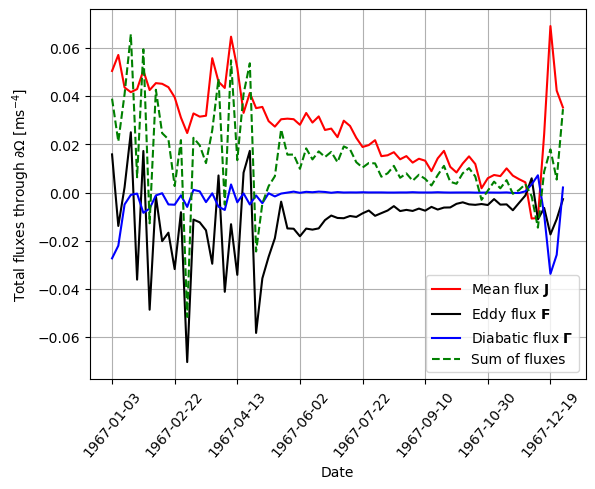

In [37]:

fig, ax = plt.subplots()
ax.grid()
ax.plot(tot_J.sum(1), 'r', label = r'Mean flux $\mathbf{J}$')
ax.plot(tot_F.sum(1), 'k', label = r'Eddy flux $\mathbf{F}$')
ax.plot(tot_G.sum(1), 'b', label = r'Diabatic flux $\mathbf{\Gamma}$')
ax.plot(tot_J.sum(1)+ tot_F.sum(1) + tot_G.sum(1), '--g', label = 'Sum of fluxes')

ax.legend()
ax.set_xticks(range(0,73,10))
# ax.set_xlim([2,38])
# ax.set_ylim([0,0.04]) 
date_label = []
for index in range(0,73,10):
    date_label.append(str(dates.date[index]))
ax.set_xticklabels(date_label,
        rotation=50)
# ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04])
# ax.set_yticklabels([0, 0.01, 0.02, 0.03, 0.04], color = 'r')
ax.set_ylabel(r'Total fluxes through $\partial \Omega$ [ms$^{-4}$]')
ax.set_xlabel('Date')

plt.savefig(figdir+'Total_flux2.eps', format = 'eps', dpi= 600, 
             bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 

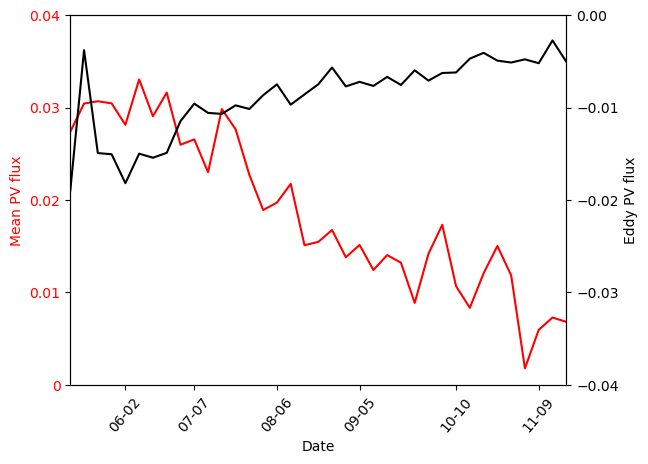

In [35]:

fig, ax = plt.subplots()

ax.plot(tot_J.sum(1)[24:63], 'r')
ax.set_xticks([1, 6, 11, 17, 23, 30, 36])
ax.set_xlim([2,38])
ax.set_ylim([0,0.04]) 
ax.set_xticklabels(['05-08','06-02', '07-07', '08-06', '09-05', 
                    '10-10', '11-09'],
       rotation=50)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04])
ax.set_yticklabels([0, 0.01, 0.02, 0.03, 0.04], color = 'r')
ax.set_xlabel('Date')
ax.set_ylabel(r'Mean PV flux', color = 'r')

ax2 = ax.twinx()
ax2.plot(tot_F.sum(1)[24:63],'k')
ax2.set_xlim([2,38]) 
ax2.set_ylim([-0.04,0])
ax2.set_yticks([-0.04, -0.03, -0.02, -0.01, 0])
# ax2.set_yticklabels([-4, -1.5, -1, -0.5, 0])
ax2.set_ylabel(r'Eddy PV flux')

plt.savefig(figdir+'Total_flux.eps', format = 'eps', dpi= 600, 
             bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 

The negative total eddy flux means that the eddy fluxes are going into the control volume, meaning that they move from high PV to low PV. That is, the eddy fluxes are down-gradient.

In [120]:
len(ntimes[0,24:67])

43

(-0.0005, 0.0005)

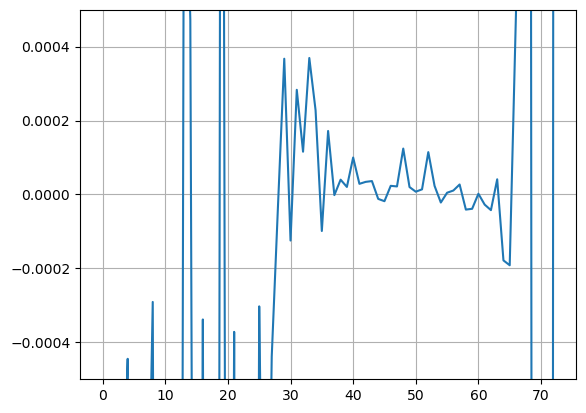

In [39]:
plt.plot(tot_G.sum(1))
plt.grid()
plt.ylim([-0.0005, 0.0005])